# <b>Generating data for Algorithm Project</b>

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import glob
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string

files1 = glob.glob('sraa/realaviation/*')
files2 = glob.glob('sraa/simaviation/*')
files3 = glob.glob('sraa/realauto/*')
files4 = glob.glob('sraa/simauto/*')


utf8 = ['\x83', '\x93', '\x97', '\xa3', '\xa7', '\xab', '\xaf', '\xb3', '\xb7', '\xbb', '\xbf', '\xc3', 
        '\xc7', '\xcb', '\xcf', '\xd3', '\xd7', '\xdb', '\xdf', '\xe3', '\xe7', '\xeb', '\xef', '\xf3', 
        '\xf7', '\xfb', '\x84', '\x88', '\x90', '\x94', '\x9c', '\xa0', '\xa4', '\xa8', '\xac', '\xb0', 
        '\xb4', '\xb8', '\xbc', '\xc0', '\xc4', '\xc8', '\xcc', '\xd0', '\xd4', '\xd8', '\xdc', '\xe0', 
        '\xe4', '\xe8', '\xec', '\xf0', '\xf4', '\xf8', '\xfc', '\x85', '\x91', '\x95', '\x99', '\xa1', 
        '\xa5', '\xa9', '\xad', '\xb1', '\xb5', '\xb9', '\xbd', '\xc1', '\xc5', '\xc9', '\xcd', '\xd1', 
        '\xd5', '\xd9', '\xdd', '\xe1', '\xe5', '\xe9', '\xed', '\xf1', '\xf5', '\xf9', '\xfd', '\x92', 
        '\x96', '\xa2', '\xa6', '\xaa', '\xae', '\xb2', '\xb6', '\xba', '\xbe', '\xc2', '\xc6', '\xca', '\xce', 
        '\xd2', '\xd6', '\xda', '\xde', '\xe2', '\xe6', '\xea', '\xee', '\xf2', '\xf6', '\xfa', '\xfe']

nontfidf = [ 'subject', 'line', 'xref', 'newsgroup', 'date', 'path', 'news.jprc.com', 'message-id']
directory = glob.glob('sraa/*')
stemmer = PorterStemmer()

In [3]:

documents = []

for folder in directory:
    print folder
    tmp = []
    files = glob.glob(folder+"/*")
    nums = 0
    for fileName in files:
        f = open(fileName,'r')
        data = f.read()
        data = ''.join(i if ord(i)<128 else ' ' for i in data )
        data = data.lower()
        
        #toker = RegexpTokenizer(r'((?<=[^\w\s])\w(?=[^\w\s])|(\W))+', gaps=True)
        #dataA = toker.tokenize(data)
        
        dataA = word_tokenize(data)
        dataA_without_punc = [i for i in dataA if i not in string.punctuation]
        
        single = ' '.join([stemmer.stem(w) for w in dataA_without_punc])
        tmp.append(single)
    documents.append(tmp)

sraa\realauto
sraa\realaviation
sraa\simauto
sraa\simaviation


In [4]:
from nltk.corpus import stopwords
from collections import defaultdict
from gensim import corpora,models, similarities

def preprocess(documents):
    # documents = ['babak is khar','hasan is good']
    stopList = stopwords.words('english')
    print len(stopList)
    texts = [[word for word in document.lower().split() if word not in stopList+nontfidf]
         for document in documents]
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    return [[token for token in text if frequency[token] > 1]
        for text in texts]
    
    
    
def makeCorpus(texts):
    # texts = [['babak', 'is' , 'khar'],['hasan', 'is','good']]
    # it means we do some preprocess like: stopword, common word, ...
    dictionary = corpora.Dictionary(texts)
    dictionary.save('dictionary.dict')
#     print dictionary.token2id
    return [dictionary.doc2bow(text) for text in texts]


In [5]:
alldocs = []
for docs in documents:
    for doc in docs:
        alldocs.append(doc)

        
texts = preprocess(alldocs)
corpus = makeCorpus(texts)
corpora.MmCorpus.serialize('run1/corpus.mm', corpus)
print len(corpus)


127
73218


In [6]:
corpus = corpora.MmCorpus('run1/corpus.mm')

In [7]:
dictionary = corpora.Dictionary(texts)
names = ['realaviation','simaviation','realauto','simauto']

for i in range(4):
    corp = [dictionary.doc2bow(text.split()) for text in documents[i]]
    corpora.MmCorpus.serialize('run1/corpus_'+names[i]+'.mm',corp)


In [8]:
tfidf = models.TfidfModel(corpus)
vec = [(0, 1), (4, 1)]
print tfidf[vec]

[(0, 0.03049727979331613), (4, 0.9995348497802407)]


In [9]:
tfidf.save('run1/sraa.tfidf_model')

In [10]:
tfidf2 = models.TfidfModel.load('run1/sraa.tfidf_model')

In [11]:
vec2 = [(0, 1), (4, 1)]
a = tfidf2[vec2]
for i in a:
    print i[0],i[1]

0 0.0304972797933
4 0.99953484978


In [12]:
sparseData = []
for data in corpus:
    sparseData.append(tfidf2[data])

In [13]:
lens = [0,4796,22241,63592,73218]
for i in range(4):
    print lens[i+1] - lens[i]

4796
17445
41351
9626


In [37]:
names = ['run2/realaviation','run2/simaviation','run2/realauto','run2/simauto']
labels = [0,1,0,1]
start = [0,4796,22241,63592]
end = [4796,22241,63592,73218]
k = 0
def writeline(a):
    return str(a)+'\n'
for i in range(4):
    with open(names[i],'w') as f:
        f.writelines(map(str,sparseData[start[i]:end[i]]))
#         for j in range(start[i],end[i]):
#             f.write(str(sparseData[j]))

In [38]:
numFeatures = len(dictionary.keys())
print numFeatures
print len(alldocs)
print len(alldocs) + numFeatures + 2

223777
73218
296997


In [39]:
# import gensim
# corpus = gensim.matutils.Sparse2Corpus(scipy_sparse_matrix)
# scipy_csc_matrix = gensim.matutils.corpus2csc(corpus)

In [40]:
# Construct graph
from scipy import sparse
numNodes = len(alldocs) + numFeatures + 2
A = sparse.lil_matrix((numNodes,numNodes))


In [41]:
import numpy as np
L = [0,0,1,1]
labels = np.zeros(len(alldocs))
names = ['realaviation','simaviation','realauto','simauto']
start = [0,4796,22241,63592]
end = [4796,22241,63592,73218]

numFeatures = len(dictionary.keys())
numData = len(sparseData)

for i in range(4):
    if L[i] == 1:
        labels[start[i]:end[i]] = np.ones(end[i]-start[i])
    else:
        labels[start[i]:end[i]] = np.zeros(end[i]-start[i])

In [42]:
# features: 0-numFeatures
# data: numFeature-(numFeature+numData)
# label: (numFeature+numData), (numFeature+numData+1)
# connect datas to features
for i in range(numData):
    for t in sparseData[i]:
        feature,weight = t[0],t[1]
        A[i+numFeatures,feature] = weight
        A[feature,i+numFeatures] = weight

# connect datas to labels
for i in xrange(numData):
    A[numData+numFeatures+labels[i],numData+i] = 1
    A[numData+i,numData+numFeatures+labels[i]] = 1

In [43]:
numNodes = numData+numFeatures+2
mask = []
for i in range(4):
    mask.append(np.zeros(numNodes,dtype=int))
    mask[i][start[i]+numFeatures:end[i]+numFeatures] = np.ones(end[i]-start[i])

In [44]:
#construct D
N = A.shape[0]
D = sparse.lil_matrix((N,N))
a = A.sum(axis=0)
for i in range(N):
    D[i,i] = a[0,i]
L = D-A

In [45]:
for i in range(numNodes):
    if D[i,i] >-0.0001 and D[i,i] < 0.0001:
        print i, D[i,i]

In [47]:
# generalized eigenvalue decomposition  Lv = tDv
vals, vecs = sparse.linalg.eigs(L, k=120, M=D)

In [49]:
points = (vecs[0:2].real)

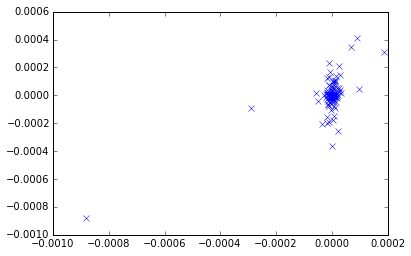

In [50]:
plt.plot(points[0],points[1],'x')

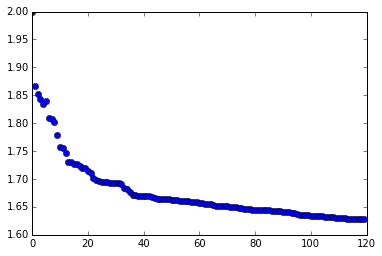

In [51]:
plt.plot(range(120),vals,'o')

In [ ]:
# import sklearn.decomposition as deco
# import numpy as np

# t = (vecs - np.mean(vecs,0))/np.std(vecs,0)
# pca = deco.PCA(2)
# t_r = pca.fit(t).transform(t)
# print ('explained variance (first %d components): %.2f'%(2, sum(pca.explained_variance_ratio_)))

In [ ]:
# plt.plot(t_r[:,0],t_r[:,1],'o')

In [65]:
import pandas as pd
savedVals = vals.real
savedVecs = pd.DataFrame(vecs.real)

In [53]:
np.savetxt('run2/vals.txt',savedVals)

(296997, 120)


TypeError: unhashable type

In [72]:
names = ['realaviation','simaviation','realauto','simauto']
for i in range(4):
    with open('vec_'+names[i]+'.txt','w') as f:
        if mask[i] == 1:
            f.write(str(savedVecs[i])+'\n')
    

296997

In [71]:


data = []
for i in range(4):
    data.append(savedVecs[mask[i]].as_matrix() )
for i in range(4):
    print len(data[i])


In [ ]:
for i in range(4):
    np.savetxt('run2/vec_'+names[i]+'.txt',data[i])

In [ ]:
a = pd.DataFrame([1,1])

In [77]:
np.savetxt('run2/vecs.txt',savedVecs)

In [78]:
numFeatures

223777

In [79]:
numData

73218